In [ ]:
# ===================================================================
# ЭТАП 3: Моделирование и настройка
# ===================================================================

print("--- Начало Исправленного Этапа 3 ---")

# Импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Шаг 3.1: ЗАГРУЗКА ДАННЫХ И ПОДГОТОВКА К ОБУЧЕНИЮ ---
data_dir = 'processed_data'

try:
    # Загружаем X_train и X_test, которые мы сохранили на Этапе 2
    # Они все еще содержат 'rating' и 'reviewCount'
    X_train_full = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
    X_test_full = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))
    
    y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv')).squeeze()
    y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).squeeze()
    
    # --- ВАЖНО: ИСКЛЮЧАЕМ ПРИЗНАКИ С УТЕЧКОЙ ДАННЫХ ---
    features_to_drop = ['rating', 'reviewCount']
    X_train = X_train_full.drop(columns=features_to_drop)
    X_test = X_test_full.drop(columns=features_to_drop)
    
    print("✅ Данные загружены.")
    print(f"Признаки с утечкой данных {features_to_drop} были исключены из X_train и X_test.")
    print(f"Данные готовы к обучению. Новый размер X_train: {X_train.shape}")

except FileNotFoundError:
    print(f"❌ Ошибка: Файлы для обучения не найдены в папке '{data_dir}'.")
    print("Пожалуйста, выполните Этап 2, чтобы создать эти файлы.")

--- Начало Исправленного Этапа 3 ---
✅ Данные загружены.
Признаки с утечкой данных ['rating', 'reviewCount'] были исключены из X_train и X_test.
Данные готовы к обучению. Новый размер X_train: (4680, 14)


In [ ]:
# --- Шаг 3.2: Сравнение моделей на  данных ---
# Теперь метрики будут ниже, но они отразят реальную предсказательную силу модели.

print("\n--- Сравнение производительности моделей без 'leaky' признаков ---")

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Обучение модели: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({'model': name, 'R2 Score': r2, 'MAE': mae})
    print(f"Результат для {name}: R2 = {r2:.3f}, MAE = {mae:.2f}\n")

results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

print("--- Итоговая таблица сравнения моделей ---")
display(results_df)

best_model_name = results_df.iloc[0]['model']
print(f"\n✅ Лучшая базовая модель по R2 Score: {best_model_name}")


--- Сравнение производительности моделей без 'leaky' признаков ---
Обучение модели: Linear Regression...
Результат для Linear Regression: R2 = 0.225, MAE = 24.97

Обучение модели: Random Forest...
Результат для Random Forest: R2 = 0.202, MAE = 25.08

Обучение модели: LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 4680, number of used features: 14
[LightGBM] [Info] Start training from score 33,461111
Результат для LightGBM: R2 = 0.202, MAE = 25.06

--- Итоговая таблица сравнения моделей ---


,model,R2 Score,MAE
0,Linear Regression,0.225394,24.973464
1,Random Forest,0.202211,25.079068
2,LightGBM,0.201573,25.063514



✅ Лучшая базовая модель по R2 Score: Linear Regression


In [7]:
# --- Шаг 3.3: Тонкая настройка лучшей модели ---
# Настраивать будем LightGBM, так как он обычно самый быстрый и хорошо поддается тюнингу.

print(f"\n--- Тонкая настройка модели LightGBM ---")

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgbm_for_tuning = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm_for_tuning, 
    param_distributions=param_grid, 
    n_iter=25,
    cv=3, 
    scoring='r2', 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
)

print("Начинаем поиск лучших гиперпараметров...")
random_search.fit(X_train, y_train)

best_lgbm_tuned = random_search.best_estimator_
print("\nНайдены лучшие параметры для LightGBM:")
print(random_search.best_params_)

# Оцениваем финальную, настроенную модель
y_pred_final = best_lgbm_tuned.predict(X_test)
y_pred_final[y_pred_final < 0] = 0

final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)

print("\n--- Качество финальной, настроенной модели ---")
print(f"R2 Score: {final_r2:.4f}")
print(f"MAE: {final_mae:.2f} поездок")


--- Тонкая настройка модели LightGBM ---
Начинаем поиск лучших гиперпараметров...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 4680, number of used features: 14
[LightGBM] [Info] Start training from score 33,461111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[


--- Топ-15 признаков для финальной модели ---


,feature,importance
0,rate.daily,513
1,city_avg_trips,505
2,vehicle.age,371
3,city_avg_rate,174
4,city_car_count,126
5,vehicle.type_suv,78
6,state_avg_trips,63
7,state_car_count,50
8,fuelType_GASOLINE,31
9,vehicle.type_minivan,27


C:\Users\Killumy\AppData\Local\Temp\ipykernel_15200\2961638370.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(15), x='importance', y='feature', palette='viridis')


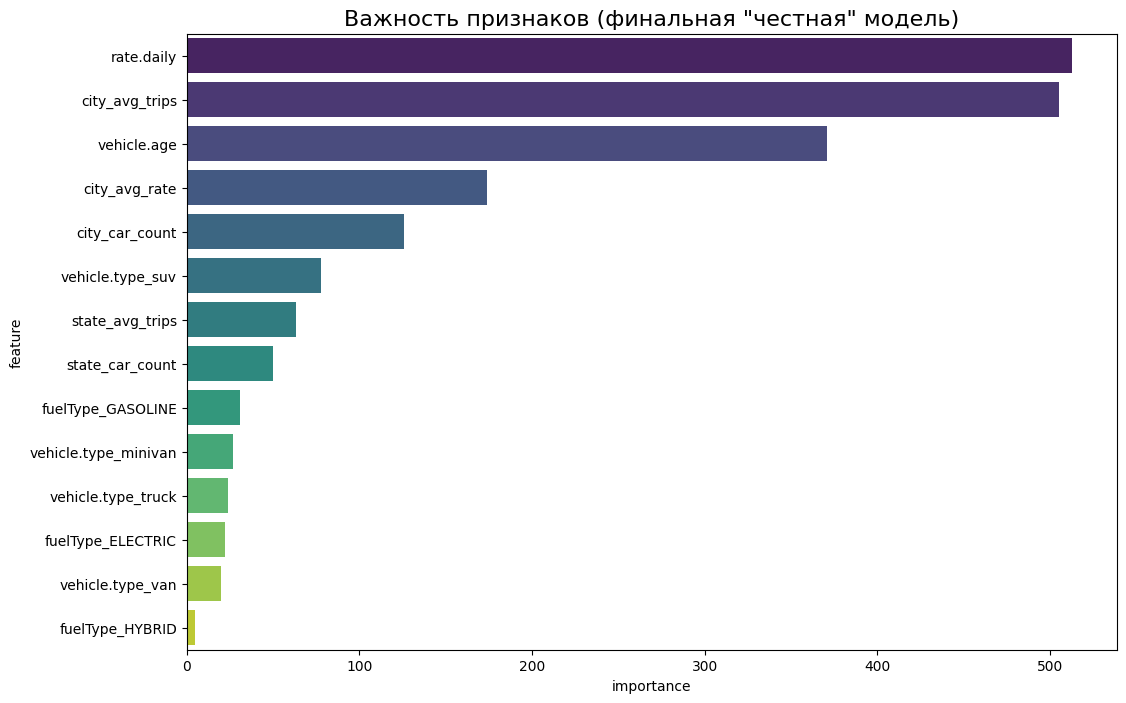


✅ Финальная настроенная и методологически корректная модель сохранена в: 'models\lgbm_model.txt'

--- Исправленный Этап 3 полностью завершен. ---


In [ ]:
# --- Шаг 3.4: Анализ финальной модели и сохранение ---

# Теперь посмотрим, какие признаки стали важны, когда модель не может "списывать" с reviewCount.
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgbm_tuned.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n--- Топ-15 признаков для финальной модели ---")
display(feature_importances.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(15), x='importance', y='feature', palette='viridis')
plt.title('Важность признаков (финальная "честная" модель)', fontsize=16)
plt.show()

# --- Сохранение финальной модели ---
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'lgbm_model.txt')

# Перезаписываем старую "нечестную" модель нашей новой, правильной.
best_lgbm_tuned.booster_.save_model(model_path)

print(f"\n✅ Финальная настроенная и методологически корректная модель сохранена в: '{model_path}'")
print("\n--- Исправленный Этап 3 полностью завершен. ---")